In [9]:
%matplotlib inline
import numpy as np
import os.path
from PIL import Image
from matplotlib import pyplot as plt
import cv2

In [10]:
DATA_DIR = '.'

TEST_SMALL = os.path.join(DATA_DIR, 'test_small.jpg')
TEST_BIG = os.path.join(DATA_DIR, 'test_big.jpg')

In [11]:
def open_img(name):
    img = Image.open(name)
    return (img, np.array(img.convert('L')))

test_small = open_img(TEST_SMALL)
test_big = open_img(TEST_BIG)

In [12]:
def max_min(is_dilation):
    if is_dilation:
        return max
    return min

In [38]:
def compute_line(f, k, is_dilation):
    m = len(f)
    PSA = (k - (m - 1) % k) - 1
    g = [0 for _ in range(m)]
    for x in range(m):
        if x % k == 0:
            g[x] = f[x]
        else:
            g[x] = max_min(is_dilation)(g[x-1], f[x])
    h = [0 for _ in range(m)]
    for x in range(m-1, -1, -1):
        if x == m-1 or (x + 1) % k == 0:
            h[x] = f[x]
        else:
            h[x] = max_min(is_dilation)(h[x+1], f[x])
    r = [0 for _ in range(m)]
    for x in range(m):
        if x - k // 2 < 0:
            ind = min(x + k // 2, m - 1)
            r[x] = g[ind]
        elif x + k // 2 >= m:
            if x + k // 2 < m + PSA:
                r[x] = max_min(is_dilation)(g[m-1], h[x-k//2])
            else:
                r[x] = h[x-k//2]
        else:
            r[x] = max_min(is_dilation)(g[x+k//2], h[x-k//2])
    return r


def HGW_line(img, k, isDilation):
    new_img = []
    for line in img:
        new_img.append(compute_line(line, k, isDilation))
    return np.array(new_img)


def HGW(img, k, isDilation):
    temp_img = HGW_line(img, k, isDilation)
    new_img = HGW_line(np.transpose(temp_img), k, isDilation)
    return np.transpose(new_img)


def ideal_algo(img, k, isDilation):
    kernel = np.ones((k, k),np.uint8)
    if isDilation:
        return cv2.dilate(img, kernel, iterations=1)
    else:
        return cv2.erode(img, kernel, iterations=1)

In [25]:
def show_result(name, src, dst):
    SIZE = 15
    plt.figure(figsize=(SIZE, SIZE))
    plt.subplot(121)
    plt.imshow(src, cmap='gray')
    plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122)
    plt.imshow(dst, cmap='gray')
    plt.title(name)
    plt.xticks([]), plt.yticks([])
    plt.show()

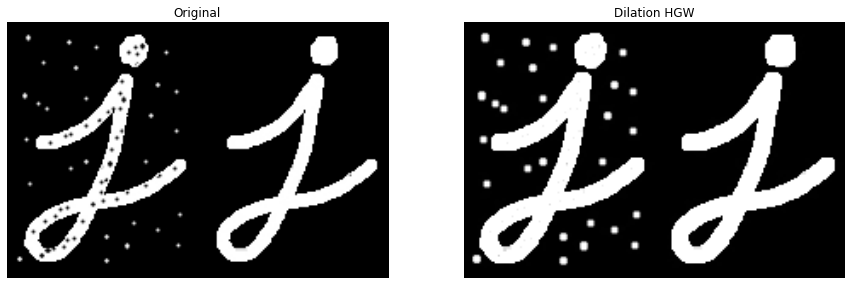

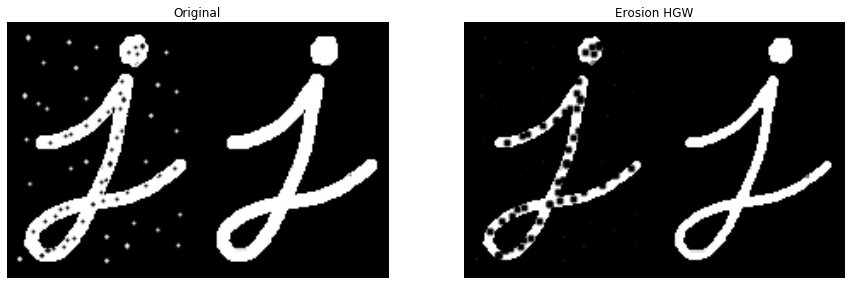

In [35]:
result_dilation = HGW(test_small[1], 2, True)
result_dilation_img = Image.fromarray(result_dilation, mode='L')
show_result('Dilation HGW', test_small[0], result_dilation_img)
result_erosion = HGW(test_small[1], 2, False)
result_erosion_img = Image.fromarray(result_erosion, mode='L')
show_result('Erosion HGW', test_small[0], result_erosion_img)

In [36]:
def find_errors(arr1, arr2):
    diff = arr1 - arr2
    count = 0
    for y in range(arr1.shape[0]):
        for x in range(arr1.shape[1]):
            if diff[y][x] != 0:
                print(y, x, diff[y][x])
                count += 1
    print('Total errors count', count)

In [40]:
import tqdm
for r in tqdm.tqdm(range(1, 2000, 2)):
    result_dilation = HGW(test_big[1], r, True)
    ideal_dilation = ideal_algo(test_big[1], r, True)
    if not np.array_equal(result_dilation, ideal_dilation):
        print('Fail a dilation test with r =', r)
    result_erosion = HGW(test_big[1], r, False)
    ideal_erosion = ideal_algo(test_big[1], r, False)
    if not np.array_equal(result_erosion, ideal_erosion):
        print('Fail an erosion test with r =', r)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [5:52:18<00:00, 18.07s/it]
